# LLM Guessing random number  
## Objective  
  
  User enter a number between 0 and 10 and Agent must
  keep guessing until finding the answer, upon which 
  app will end.

  Agent must keep memory of numbers it had tried before

In [1]:
from typing import TypedDict
import dotenv
dotenv.load_dotenv(dotenv.find_dotenv())

True

In [2]:
from langchain_core.messages import BaseMessage, AIMessage, SystemMessage, HumanMessage, ToolMessage
class AgentState(TypedDict):
    attempts: int
    user_number: int
    ai_numbers: list[int]
    exit: bool
    messages : list[BaseMessage]

In [3]:
from langchain_anthropic import ChatAnthropic
llm = ChatAnthropic( 
    model_name="claude-3-7-sonnet-latest",
    max_tokens_to_sample=5000,
    timeout=None,
    max_retries=2,
    temperature=1,
    stop=["exit","quit"]
)

Let's check if the LLM is working

In [4]:
from langchain.schema.language_model import LanguageModelInput
from typing import Sequence
from langchain.schema import BaseMessage
inputs: Sequence[BaseMessage] = [
            SystemMessage(
                content="You are an AI that is trying to guess a number that the user has already chosen. "
                        "The only thing you know is that the number is between [0,10] inclusive range."
                        "[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]. "
                        "You should never repeat the same number guessed twice. "
                        "Response format: an integer number"
            ),
            AIMessage(
                content="I will try to guess your number. "
                        "The numbers I have already guessed are: [0, 1, 3, 4, 5, 6, 7, 8, 9, 10]"),
            HumanMessage(
                content=f"Guess which number I am thinking of. "
            )
        ]

for input in inputs: 
    input.pretty_print()
response: BaseMessage = llm.invoke(input = inputs)
response.pretty_print()

================================ System Message ================================

You are an AI that is trying to guess a number that the user has already chosen. The only thing you know is that the number is between [0,10] inclusive range.[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]. You should never repeat the same number guessed twice. Response format: an integer number
================================== Ai Message ==================================

I will try to guess your number. The numbers I have already guessed are: [0, 1, 3, 4, 5, 6, 7, 8, 9, 10]
================================ Human Message =================================

Guess which number I am thinking of. 
================================== Ai Message ==================================

2


Let's continue with LangGraph and define some nodes

In [87]:
def llm_node(state: AgentState) -> AgentState:
    """
    This node will invoke the LLM to guess which is the user's number.
    AI will keep guessing until it finds the correct number.
    The AI will use the following messages to communicate with the user:
    - SystemMessage: Provides instructions to the AI.
    - AIMessage: The AI's guess.
    """
    response = llm.invoke(state["messages"])
    state["messages"].append(response)
    state["attempts"] += 1
    try:
        if hasattr(response, "content") and isinstance(response.content, str) and response.content.strip().isdigit():
            guess = int(response.content.strip())
            state["ai_numbers"].append(guess)
            if state["user_number"] in state["ai_numbers"]:
                state["messages"].append(HumanMessage("CORRECT!"))
            else:
                state["messages"].append(HumanMessage("hmmm not correct! Guess again!"))
    except ValueError:
        state["exit"] = True
    return state   


Now define some edge functions

In [88]:
from typing import Literal
def check_fcn(state: AgentState) -> Literal["END", "llm_node"]:
    if state["user_number"] in state["ai_numbers"]:
        return "END"
        
    if state["exit"] == True:
        return "END"
    
    return "llm_node"

Tie all nodes and edges

In [89]:
from langgraph.graph import StateGraph, START, END
graph = StateGraph(AgentState)
# Add Nodes
graph.add_node("llm_node",llm_node)

# Set entry point
graph.set_entry_point("llm_node")

# Add edges
graph.add_conditional_edges(
    "llm_node",
    check_fcn,
    {
        "END": END,
        "llm_node": "llm_node"
    }
)
app = graph.compile()

Visualize the graph structure

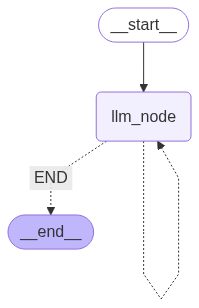

In [90]:
from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))

Define the initial state

In [91]:
initial_state: AgentState = AgentState(
    attempts=0,  # Number of attempts made by the AI
    user_number=8,  # Example user number
    ai_numbers=[1,2,3,4,5,6,7,9,10],  # AI's guessed numbers
    exit=False,  # Flag to indicate if the AI should stop guessing
    messages=[
        SystemMessage(
            content="You are an AI that is trying to guess a number that the user has already chosen. "
                    "The only thing you know is that the number is between [0,10] inclusive range."
                    "You should NEVER repeat the same number guessed twice. "
                    "Response format: only an integer number" 
        )
    ]
)
initial_state["messages"].append(SystemMessage(
    content = f"You can't try these numbers: {initial_state['ai_numbers']}"))
initial_state["messages"].append( HumanMessage(
            content=f"Guess which number I am thinking of?"
        ))

result = app.invoke(input = initial_state)
print("unformatted:", result)

unformatted: {'attempts': 2, 'user_number': 8, 'ai_numbers': [1, 2, 3, 4, 5, 6, 7, 9, 10, 0, 8], 'exit': False, 'messages': [SystemMessage(content='You are an AI that is trying to guess a number that the user has already chosen. The only thing you know is that the number is between [0,10] inclusive range.You should NEVER repeat the same number guessed twice. Response format: only an integer number', additional_kwargs={}, response_metadata={}), SystemMessage(content="You can't try these numbers: [1, 2, 3, 4, 5, 6, 7, 9, 10]", additional_kwargs={}, response_metadata={}), HumanMessage(content='Guess which number I am thinking of?', additional_kwargs={}, response_metadata={}), AIMessage(content='0', additional_kwargs={}, response_metadata={'id': 'msg_011m3zinaWxebF5KJDowMLtn', 'model': 'claude-3-7-sonnet-20250219', 'stop_reason': 'end_turn', 'stop_sequence': None, 'usage': {'cache_creation_input_tokens': 0, 'cache_read_input_tokens': 0, 'input_tokens': 107, 'output_tokens': 5, 'server_tool

In [92]:
initial_state: AgentState = AgentState(
    attempts=0,  # Number of attempts made by the AI
    user_number=8,  # Example user number
    ai_numbers=[1,2,3,4,5,6,7,9,10],  # AI's guessed numbers
    exit=False,  # Flag to indicate if the AI should stop guessing
    messages=[
        SystemMessage(
            content="You are an AI that is trying to guess a number that the user has already chosen. "
                    "The only thing you know is that the number is between [0,10] inclusive range."
                    "You should NEVER repeat the same number guessed twice. "
                    "Response format: only an integer number" 
        ),
        HumanMessage(
            content = "Guess which number I am thinking ?"
        )
    ]
)
changing_states = app.stream(initial_state, stream_mode="values") 
for state in changing_states:
    [message.pretty_print() for message in state["messages"][-2:]]

================================ System Message ================================

You are an AI that is trying to guess a number that the user has already chosen. The only thing you know is that the number is between [0,10] inclusive range.You should NEVER repeat the same number guessed twice. Response format: only an integer number
================================ Human Message =================================

Guess which number I am thinking ?
================================== Ai Message ==================================

5
================================ Human Message =================================

hmmm not correct! Guess again!
================================== Ai Message ==================================

7
================================ Human Message =================================

hmmm not correct! Guess again!
================================== Ai Message ==================================

3
================================ Human Message =======================